In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import scipy.stats
#from scipy.stats import norm
import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import pymc3 as pm
import arviz as az

import datetime
%matplotlib inline

#sns.set(style="dark")
plt.style.use("ggplot")

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Navigation
[Data Loading](#1)  

[EDA](#7)  
- [EDA for Full Dataset](#8)
- [EDA for Sample](#9)

[Causal Inference](#2)  
  
[GLMs](#3)  
- [Bayesian GLMs](#10) 
- [Frequentist GLMs](#11)
  
[Non-Parametric Methods](#4)
  
- [Decision Trees](#5)
<br>
- [Random Forests](#6)


<a id="1"></a>


# Data Loading

#### TLC Data

In [2]:
#Data parquet downloaded from: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
parquet_data = pd.read_parquet('fhvhv_tripdata_2022-04.parquet', engine='pyarrow')

#filters for relevant variables
data = parquet_data[['hvfhs_license_num',
                     'pickup_datetime',
                     'dropoff_datetime',
                     'trip_miles',
                     'trip_time',
                     'base_passenger_fare',
                     'tolls',
                     'bcf',
                     'sales_tax',
                     'congestion_surcharge',
                     'airport_fee',
                     'tips',
                     'driver_pay']]

#filters for Uber rides
data = data[data['hvfhs_license_num'] == 'HV0003']

#gets the date and hour of ride pickup
data['dateandhour'] = data['pickup_datetime'].dt.strftime("%Y-%m-%d %H")

#gets trip time in minutes
data['trip_minutes'] = data['trip_time']/60

#filters for only the first full week of april
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data = data[(data['pickup_datetime'] >= '2022-04-03') & ((data['pickup_datetime'] <= '2022-04-10'))]

#Ensures that datetime is in EST
data['pickup_datetime'] = data['pickup_datetime'].dt.tz_localize('US/Eastern')

#filters for relevant variables
data = data[['pickup_datetime',
             'dateandhour',
             'trip_miles',
             'trip_time',
             'trip_minutes',
             'base_passenger_fare',
             'tolls',
             'bcf',
             'sales_tax',
             'congestion_surcharge',
             'airport_fee',
             'tips',
             'driver_pay']]

#Adds column for hour of day that the ride occurred (ranges from 00-23)
data['hour'] = data['pickup_datetime'].dt.hour

#Adds column for day of week that ride occurred (ranges from 0-6)
data['dayofweek'] = data['pickup_datetime'].dt.dayofweek

data.head()

,pickup_datetime,dateandhour,trip_miles,trip_time,trip_minutes,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,hour,dayofweek
1380170,2022-04-03 00:03:44-04:00,2022-04-03 00,3.92,955,15.916667,46.98,0.0,1.08,3.19,2.75,0.0,0.00,38.48,0,6
1380171,2022-04-03 00:43:23-04:00,2022-04-03 00,1.51,487,8.116667,17.87,0.0,0.54,1.59,2.75,0.0,4.52,12.94,0,6
1380172,2022-04-03 00:55:29-04:00,2022-04-03 00,3.60,677,11.283333,19.11,0.0,0.57,1.70,2.75,0.0,0.00,12.04,0,6
1380173,2022-04-03 00:06:00-04:00,2022-04-03 00,1.01,355,5.916667,23.06,0.0,0.69,2.05,2.75,0.0,0.00,21.78,0,6
1380174,2022-04-03 00:20:10-04:00,2022-04-03 00,0.75,413,6.883333,18.40,0.0,0.55,1.63,2.75,0.0,0.00,20.36,0,6


#### Weather Data

In [3]:
weather = pd.read_csv('NYweather_apr.csv')
weather['datetime'] = pd.to_datetime(weather['datetime'])

#gets the date and hour of ride pickup (so it's in the same format as ride data)
weather['datetime'] = weather['datetime'].dt.strftime("%Y-%m-%d %H")

weather.head()

,datetime,temp,precipitation
0,2022-04-01 00,58.8,0.1
1,2022-04-01 01,58.4,0.1
2,2022-04-01 02,58.0,1.0
3,2022-04-01 03,58.9,0.5
4,2022-04-01 04,57.1,0.9


In [4]:
#merges TLC data with weather data
full_data = data.merge(weather, how='left', left_on='dateandhour', right_on='datetime').dropna()

In [5]:
#filters for relevant variables for GLMs + nonparametrics
relevant_data = full_data[['pickup_datetime',
                  'dateandhour',
                  'trip_miles',
                  'trip_time',
                  'trip_minutes',
                  'base_passenger_fare',
                  'driver_pay',
                  'hour',
                  'temp',
                  'precipitation',
                  'tips']]

In [6]:
#Adds column that's 1 if trip was taken on weekend, and 0 on weekday
#0 = monday
#6 = sunday
data['weekend'] = np.where((data['dayofweek'] >= 4), 1, 0)
data.dayofweek.value_counts()

5    513962
3    484870
4    469304
6    434886
2    426178
1    377081
0    357640
Name: dayofweek, dtype: int64

## Load Sample dataset
------
Sample dataset is used only for Bayesian GLMs, as our kernel did have capacity to run GLMs on the full dataset. The sample dataset contains ~1500 rows of data, as compared to the ~3M rows of data in our full dataset. We randomly sampled the sample dataset using pandas's `df.sample()` function.

In [ ]:
#sample = relevant_data.sample(frac=0.0005)
#sample.to_csv('sample.csv')

sample = pd.read_csv('sample.csv')

<a id="7"></a>
# EDA

<a id="8"></a>
## EDA for Full Dataset

<ipython-input-11-2e1cdb78462b>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = data_eda.groupby("hour").agg("mean").reset_index()


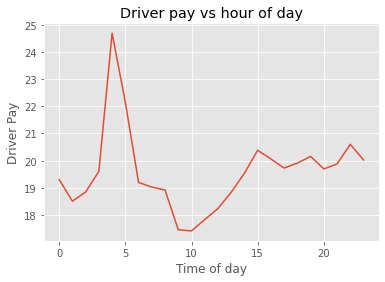

In [11]:
# plots the mean pay for each hour of the day
df = data_eda.groupby("hour").agg("mean").reset_index()

plt.plot(df["hour"], df["driver_pay"])
plt.title("Driver pay vs hour of day")
plt.xlabel("Time of day")
plt.ylabel("Driver Pay")
plt.show()

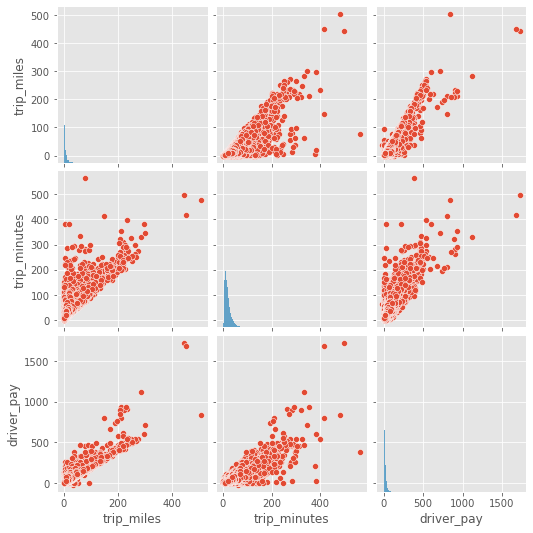

In [13]:
# plots relationships and distributions between trip_miles, trip_minutes, and driver_pay
sns.pairplot(data_eda[["trip_miles", "trip_minutes", "driver_pay"]])

<ipython-input-15-bb96ae32db9a>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.plot("hour", "driver_pay", data = data_eda[data_eda["dayofweek"] == 0].groupby("hour").agg("mean").reset_index(),
<ipython-input-15-bb96ae32db9a>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.plot("hour", "driver_pay", data = data_eda[data_eda["dayofweek"] == 1].groupby("hour").agg("mean").reset_index(),
<ipython-input-15-bb96ae32db9a>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or sele

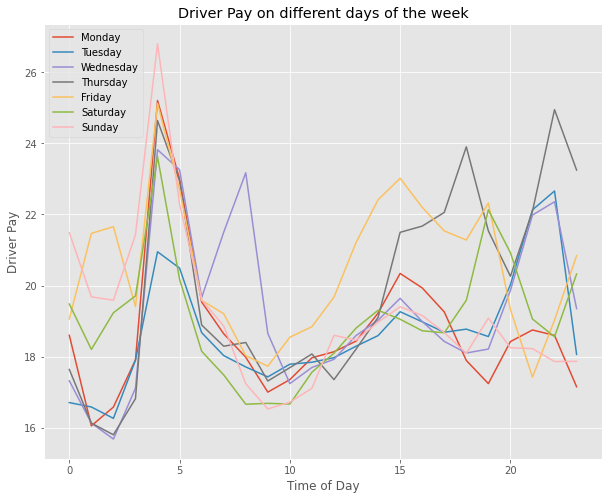

In [15]:
# plots trajectory over the course of the day on different days of the week
plt.figure(figsize = [10, 8])

plt.plot("hour", "driver_pay", data = data_eda[data_eda["dayofweek"] == 0].groupby("hour").agg("mean").reset_index(),
         label = "Monday")
plt.plot("hour", "driver_pay", data = data_eda[data_eda["dayofweek"] == 1].groupby("hour").agg("mean").reset_index(),
         label = "Tuesday")
plt.plot("hour", "driver_pay", data = data_eda[data_eda["dayofweek"] == 2].groupby("hour").agg("mean").reset_index(),
         label = "Wednesday")
plt.plot("hour", "driver_pay", data = data_eda[data_eda["dayofweek"] == 3].groupby("hour").agg("mean").reset_index(),
         label = "Thursday")
plt.plot("hour", "driver_pay", data = data_eda[data_eda["dayofweek"] == 4].groupby("hour").agg("mean").reset_index(),
         label = "Friday")
plt.plot("hour", "driver_pay", data = data_eda[data_eda["dayofweek"] == 5].groupby("hour").agg("mean").reset_index(),
         label = "Saturday")
plt.plot("hour", "driver_pay", data = data_eda[data_eda["dayofweek"] == 6].groupby("hour").agg("mean").reset_index(),
         label = "Sunday")

plt.legend()
plt.title("Driver Pay on different days of the week")
plt.xlabel("Time of Day")
plt.ylabel("Driver Pay")
plt.show();

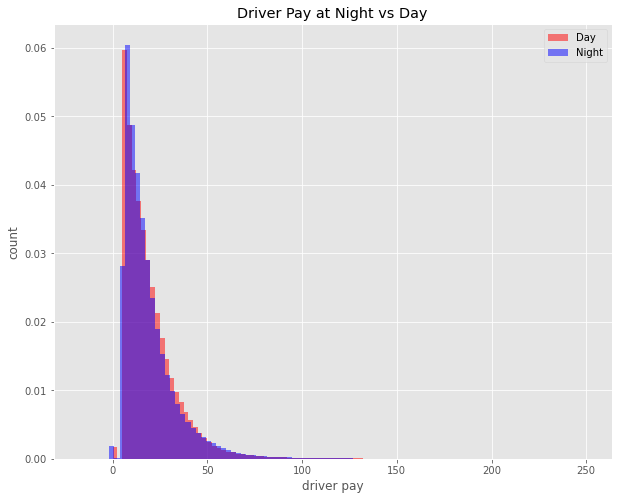

In [16]:
# plots histograms of driver pay at night and during the day

plt.figure(figsize = [10, 8])

df = data_eda[["timeofday", "driver_pay"]][data_eda["driver_pay"] <250]

plt.hist(df[df["timeofday"] == 1]["driver_pay"], bins = 100, density = True, alpha = 0.5, facecolor = 'r', label = "Day")
plt.hist(df[df["timeofday"] == 0]["driver_pay"], bins = 100, density = True, alpha = 0.5, facecolor = 'b', label = "Night")

# plt.xticks(Lbins) # to set the ticks according to the bins
plt.xlabel('driver pay')
plt.ylabel('count')
plt.title("Driver Pay at Night vs Day")
plt.legend()
plt.show()


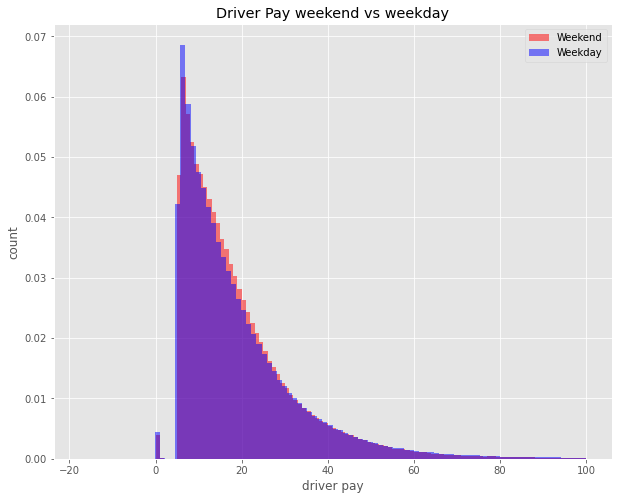

In [18]:
#plots histograms of driver pay on weekdays vs the weekend

plt.figure(figsize = [10, 8])

df = data_eda[["weekend", "driver_pay"]][data_eda["driver_pay"] <100]

plt.hist(df[df["weekend"] == 1]["driver_pay"], bins = 100, density = True, alpha = 0.5, facecolor = 'r', label = "Weekend")
plt.hist(df[df["weekend"] == 0]["driver_pay"], bins = 100, density = True, alpha = 0.5, facecolor = 'b', label = "Weekday")

# plt.xticks(Lbins) # to set the ticks according to the bins
plt.xlabel('driver pay')
plt.ylabel('count')
plt.title("Driver Pay weekend vs weekday")
plt.legend()
plt.show()

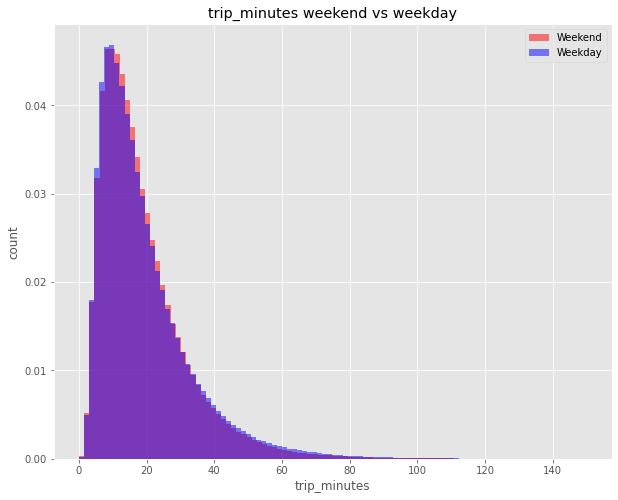

In [21]:
#plots histograms of trip minutes on weekdays vs the weekend

plt.figure(figsize = [10, 8])

df = data_eda[["weekend", "trip_minutes"]][data_eda["trip_minutes"] <150]

plt.hist(df[df["weekend"] == 1]["trip_minutes"], bins = 100, density = True, alpha = 0.5, facecolor = 'r', label = "Weekend")
plt.hist(df[df["weekend"] == 0]["trip_minutes"], bins = 100, density = True, alpha = 0.5, facecolor = 'b', label = "Weekday")

# plt.xticks(Lbins) # to set the ticks according to the bins
plt.xlabel('trip_minutes')
plt.ylabel('count')
plt.title("trip_minutes weekend vs weekday")
plt.legend()
plt.show()

<ipython-input-28-6ba9253321ac>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = relevant_data.groupby("temp").agg("mean").reset_index()


Text(0.5, 1.0, 'average driver pay vs temperature')

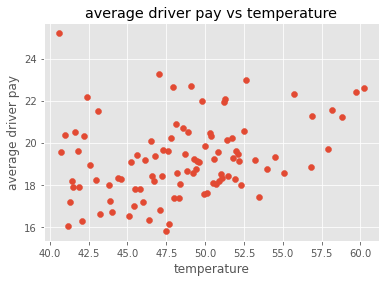

In [28]:
# plots scatterplot between temperature and average driver pay 
df = relevant_data.groupby("temp").agg("mean").reset_index()

plt.scatter("temp", "driver_pay", data = df)
plt.xlabel("temperature")
plt.ylabel("average driver pay")
plt.title("average driver pay vs temperature")

<ipython-input-32-19d04b9a844c>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = relevant_data.groupby("precipitation").agg("mean").reset_index()


Text(0.5, 1.0, 'average driver pay vs precipitation')

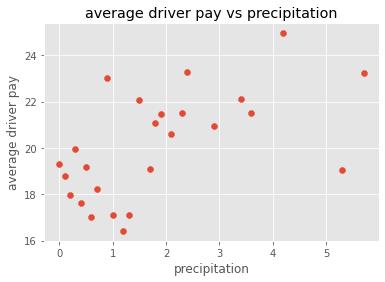

In [32]:
# plots scatterplot between precipitation and average driver pay 

df = relevant_data.groupby("precipitation").agg("mean").reset_index()

plt.scatter("precipitation", "driver_pay", data = df)
plt.xlabel("precipitation")
plt.ylabel("average driver pay")
plt.title("average driver pay vs precipitation")

<a id="8"></a>
## EDA for Sample data (used for Bayesian GLMs)

- Determining if there is correlation between variables

<ipython-input-5-65e1158b05e1>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


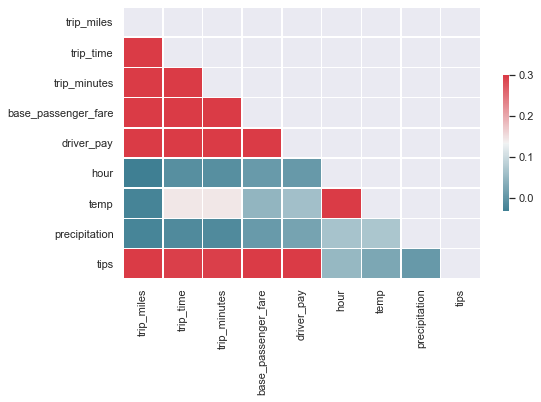

In [5]:
# Compute the correlation matrix
corr = sample.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    ax=ax,
);

### Distribution of  `driver_pay`
______
May be useful in understanding the performance of predicting tips with the non-parametrics

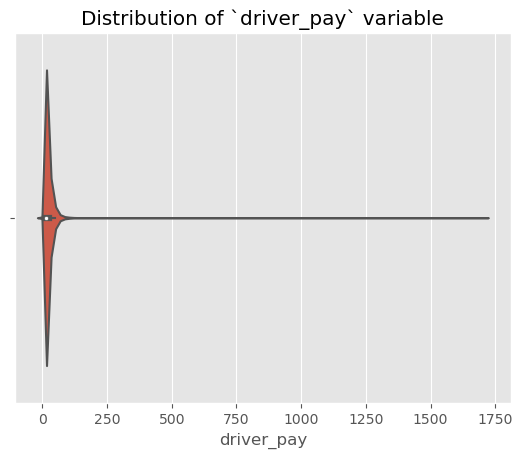

In [13]:
sns.violinplot(data=relevant_data,
               x=relevant_data['driver_pay'])
plt.title('Distribution of `driver_pay` variable')
plt.show()

In [14]:
#Gets general summary statistics about the `tips` variable
relevant_data[['driver_pay']].describe()

,driver_pay
count,3.063921e+06
mean,1.943174e+01
std,1.565642e+01
min,-1.778000e+01
25%,9.250000e+00
50%,1.512000e+01
75%,2.446000e+01
max,1.721680e+03


<a id="2"></a>


# Causal Inference

Run the regression model, accounting for confounding variables.

In [50]:
x = data[['weekend', 'trip_minutes', 'trip_miles', 'base_passenger_fare']]
y = data['driver_pay']
 
# with sklearn
regr = LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 0.37620029274998146
Coefficients: 
 [0.11126075 0.26632295 0.52809423 0.46094742]
                            OLS Regression Results                            
Dep. Variable:             driver_pay   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                 1.208e+07
Date:                Sun, 04 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:39:35   Log-Likelihood:            -8.4568e+06
No. Observations:             3063921   AIC:                         1.691e+07
Df Residuals:                 3063916   BIC:                         1.691e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

<a id="3"></a>
# GLMs

- Goal: predict `driver_pay` from variables of interest

<a id="10"></a>
## Bayesian GLMs

## `trip_miles`
------
Predicting `driver_pay` with `trip_miles`

#### Draw posterior samples from 3 models:
1) Gaussian
2) Poisson
3) Negative Binomial

In [35]:
# Bayesian regression model using Gaussian likelihood (equivalent to OLS)
with pm.Model() as gaussian_model:
    glm.GLM.from_formula('driver_pay ~ trip_miles', 
                        data = sample)
    # draw posterior samples using NUTS sampling
    gaussian_trace = pm.sample(1000, cores=1, target_accept=0.95, return_inferencedata = True)
    
# Poisson model
with pm.Model() as poisson_model:
    glm.GLM.from_formula('driver_pay ~ trip_miles', 
                         data = sample,
                         family=glm.families.Poisson())
    # draw posterior samples using NUTS sampling
    poisson_trace = pm.sample(1000, init='map', cores=1, target_accept=0.95, return_inferencedata = True)
    
#Negative Binomial model
with pm.Model() as negbin_model:
    glm.GLM.from_formula('driver_pay ~ trip_miles', 
                         data = sample,
                         family=glm.families.NegativeBinomial())
    # draw posterior samples using NUTS sampling
    negbin_trace = pm.sample(1000, cores=1, target_accept=0.95, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, trip_miles, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using map...


Sequential sampling (2 chains in 1 job)
NUTS: [mu, trip_miles, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 761 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, mu, trip_miles, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 36 seconds.


#### Draw posterior predictive samples from 3 models

In [36]:
# Draw posterior predictive samples from Gaussian model
with gaussian_model:
    gaussian_ppc = pm.sample_posterior_predictive(
        gaussian_trace, var_names=['trip_miles', "Intercept", "y"]
    )

# Draw posterior predictive samples from Poisson model
with poisson_model:
    poisson_ppc = pm.sample_posterior_predictive(
        poisson_trace, var_names=["trip_miles", "Intercept", "y"]
    )

# Draw posterior predictive samples from Negative Binomial model
with negbin_model:
    negbin_ppc = pm.sample_posterior_predictive(
        negbin_trace, var_names=["trip_miles", "Intercept", "y"]
    )

In [37]:
#Computes the average of the posterior predictive distribution
def compute_avg_prediction(ppc):
    linear_part = np.outer(ppc["trip_miles"], sample.trip_miles.values) + ppc["Intercept"][:,np.newaxis]
    return linear_part

In [38]:
y_hat_poisson = compute_avg_prediction(poisson_ppc)
y_hat_negbin = compute_avg_prediction(negbin_ppc)
y_hat_gaussian = compute_avg_prediction(gaussian_ppc)
y_hat_vals = [y_hat_poisson, y_hat_gaussian, y_hat_negbin]

#### Plots the posterior predictive distribution for each model

/opt/conda/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


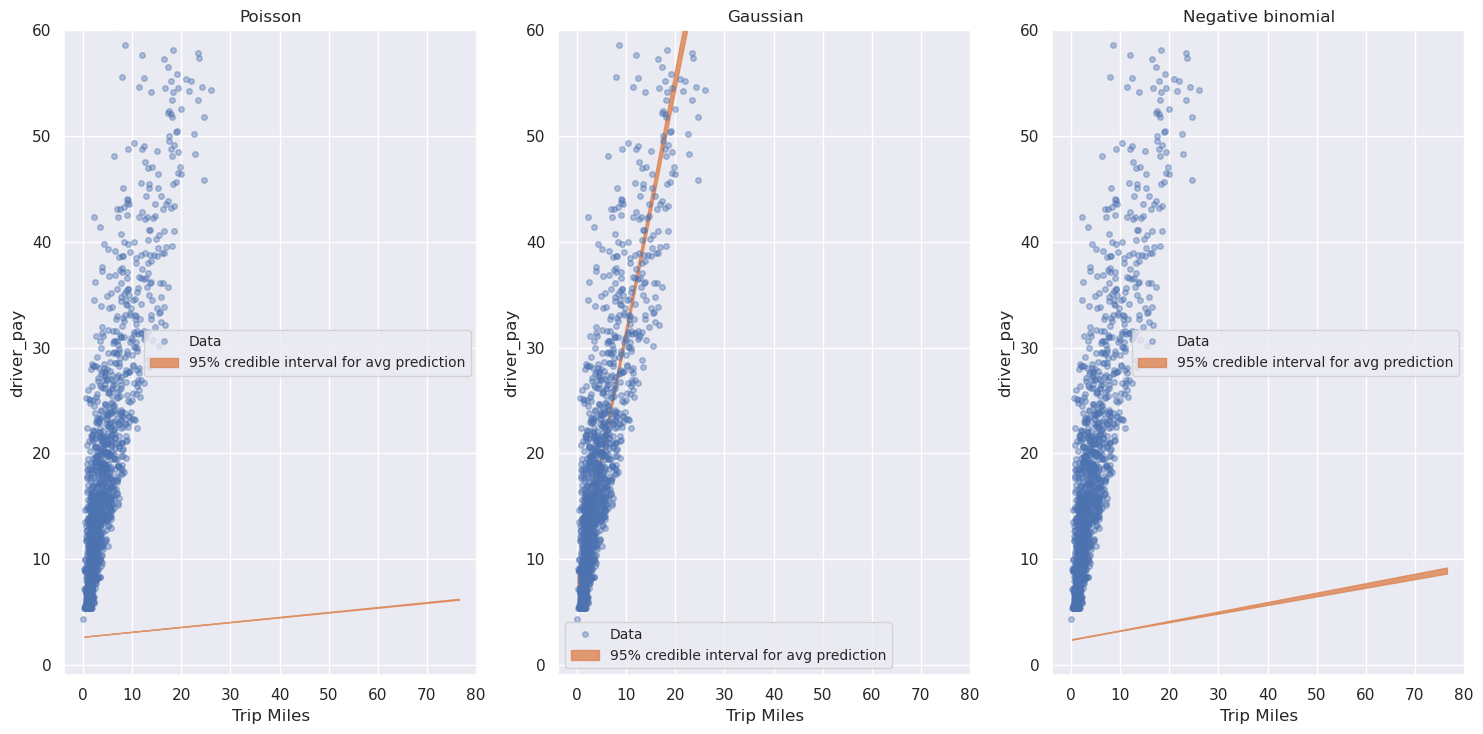

In [39]:
_, ax = plt.subplots(1,3, figsize = (15,7.5), dpi=100)
names = ["Poisson", "Gaussian", "Negative binomial"]

for idx, ppc in enumerate([poisson_ppc, gaussian_ppc, negbin_ppc]):
    ax[idx].plot(sample.trip_miles, sample.driver_pay, "o", ms=4, alpha=0.4, label="Data")
    az.plot_hdi(
        sample.trip_miles,
        y_hat_vals[idx],
        ax=ax[idx],
        hdi_prob=0.95,
        fill_kwargs={"alpha": 0.8, "label": "95% credible interval for avg prediction"},
    )
    if idx==1:
        pp_y = np.exp(ppc["y"])
    else:
        pp_y = ppc["y"]

    ax[idx].set_xlabel("Trip Miles")
    ax[idx].set_ylabel("driver_pay")
    ax[idx].set_title(names[idx])
    ax[idx].legend(fontsize=10)
    ax[idx].set_ylim(-1, 60)
plt.tight_layout()

## `trip_minutes`
------
Predicting `driver_pay` with `trip_minutes`

#### Draw posterior samples from 3 models:
1) Gaussian
2) Poisson
3) Negative Binomial

In [40]:
# Bayesian regression model using Gaussian likelihood (equivalent to OLS)
with pm.Model() as gaussian_model:
    glm.GLM.from_formula('driver_pay ~ trip_minutes', 
                        data = sample)
    # draw posterior samples using NUTS sampling
    gaussian_trace = pm.sample(1000, cores=1, target_accept=0.95, return_inferencedata = True)
    
# Poisson model
with pm.Model() as poisson_model:
    glm.GLM.from_formula('driver_pay ~ trip_minutes', 
                         data = sample,
                         family=glm.families.Poisson())
    # draw posterior samples using NUTS sampling
    poisson_trace = pm.sample(1000, init='adapt_diag', cores=1, target_accept=0.95, return_inferencedata = True)
    
#Negative Binomial model
with pm.Model() as negbin_model:
    glm.GLM.from_formula('driver_pay ~ trip_minutes', 
                         data = sample,
                         family=glm.families.NegativeBinomial())
    # draw posterior samples using NUTS sampling
    negbin_trace = pm.sample(1000, cores=1, target_accept=0.95, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, trip_minutes, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu, trip_minutes, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, mu, trip_minutes, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 53 seconds.


#### Draw posterior predictive samples from 3 models

In [41]:
# Draw posterior predictive samples from Gaussian model
with gaussian_model:
    gaussian_ppc = pm.sample_posterior_predictive(
        gaussian_trace, var_names=['trip_minutes', "Intercept", "y"]
    )

# Draw posterior predictive samples from Poisson model
with poisson_model:
    poisson_ppc = pm.sample_posterior_predictive(
        poisson_trace, var_names=["trip_minutes", "Intercept", "y"]
    )

# Draw posterior predictive samples from Negative Binomial model
with negbin_model:
    negbin_ppc = pm.sample_posterior_predictive(
        negbin_trace, var_names=["trip_minutes", "Intercept", "y"]
    )

In [42]:
#Computes the average of the posterior predictive distribution
def compute_avg_prediction(ppc):
    linear_part = np.outer(ppc["trip_minutes"], sample.trip_minutes.values) + ppc["Intercept"][:,np.newaxis]
    return linear_part

In [43]:
y_hat_poisson = compute_avg_prediction(poisson_ppc)
y_hat_negbin = compute_avg_prediction(negbin_ppc)
y_hat_gaussian = compute_avg_prediction(gaussian_ppc)
y_hat_vals = [y_hat_poisson, y_hat_gaussian, y_hat_negbin]

#### Plots the posterior predictive distribution for each model

/opt/conda/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


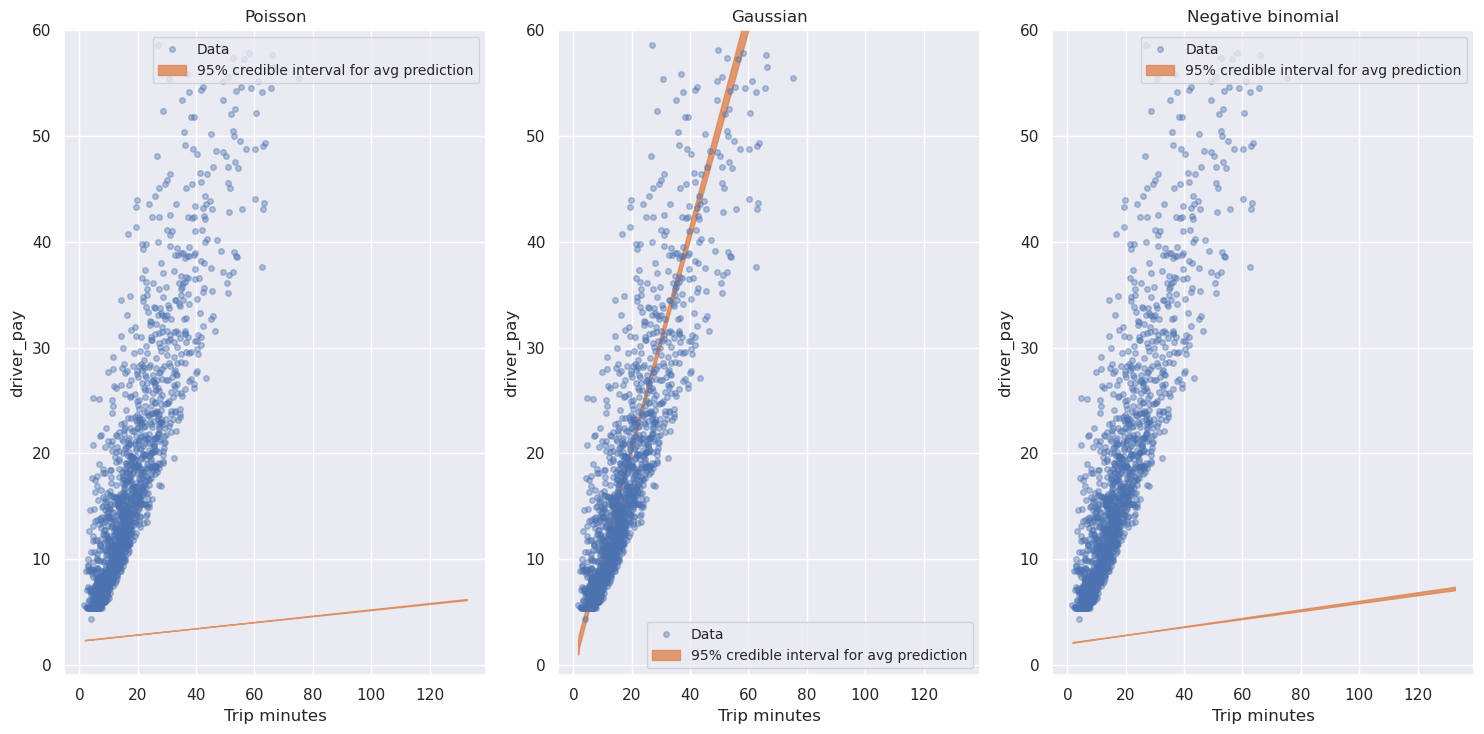

In [44]:
_, ax = plt.subplots(1,3, figsize = (15,7.5), dpi=100)
names = ["Poisson", "Gaussian", "Negative binomial"]

for idx, ppc in enumerate([poisson_ppc, gaussian_ppc, negbin_ppc]):
    ax[idx].plot(sample.trip_minutes,
                 sample.driver_pay, "o", ms=4, alpha=0.4, label="Data")
    az.plot_hdi(
        sample.trip_minutes,
        y_hat_vals[idx],
        ax=ax[idx],
        hdi_prob=0.95,
        fill_kwargs={"alpha": 0.8, "label": "95% credible interval for avg prediction"},
    )
    if idx==1:
        pp_y = np.exp(ppc["y"])
    else:
        pp_y = ppc["y"]

    ax[idx].set_xlabel("Trip minutes")
    ax[idx].set_ylabel("driver_pay")
    ax[idx].set_title(names[idx])
    ax[idx].legend(fontsize=10)
    ax[idx].set_ylim(-1, 60)
plt.tight_layout()

## `precipitation`
------
Predicting `driver_pay` with `precipitation`

#### Draw posterior samples from 3 models:
1) Gaussian
2) Poisson
3) Negative Binomial

In [45]:
# Bayesian regression model using Gaussian likelihood (equivalent to OLS)
with pm.Model() as gaussian_model:
    glm.GLM.from_formula('driver_pay ~ precipitation', 
                        data = sample)
    # draw posterior samples using NUTS sampling
    gaussian_trace = pm.sample(1000, cores=1, target_accept=0.95, return_inferencedata = True)
    
# Poisson model
with pm.Model() as poisson_model:
    glm.GLM.from_formula('driver_pay ~ precipitation', 
                         data = sample,
                         family=glm.families.Poisson())
    # draw posterior samples using NUTS sampling
    poisson_trace = pm.sample(1000, init='adapt_diag', cores=1, target_accept=0.95, return_inferencedata = True)
    
#Negative Binomial model
with pm.Model() as negbin_model:
    glm.GLM.from_formula('driver_pay ~ precipitation', 
                         data = sample,
                         family=glm.families.NegativeBinomial())
    # draw posterior samples using NUTS sampling
    negbin_trace = pm.sample(1000, cores=1, target_accept=0.95, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, precipitation, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu, precipitation, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 24 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, mu, precipitation, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.


#### Draw posterior predictive samples from 3 models

In [46]:
# Draw posterior predictive samples from Gaussian model
with gaussian_model:
    gaussian_ppc = pm.sample_posterior_predictive(
        gaussian_trace, var_names=['precipitation', "Intercept", "y"]
    )

# Draw posterior predictive samples from Poisson model
with poisson_model:
    poisson_ppc = pm.sample_posterior_predictive(
        poisson_trace, var_names=["precipitation", "Intercept", "y"]
    )

# Draw posterior predictive samples from Negative Binomial model
with negbin_model:
    negbin_ppc = pm.sample_posterior_predictive(
        negbin_trace, var_names=["precipitation", "Intercept", "y"]
    )

In [47]:
#Computes the average of the posterior predictive distribution
def compute_avg_prediction(ppc):
    linear_part = np.outer(ppc["precipitation"], sample.precipitation.values) + ppc["Intercept"][:,np.newaxis]
    return linear_part

In [48]:
y_hat_poisson = compute_avg_prediction(poisson_ppc)
y_hat_negbin = compute_avg_prediction(negbin_ppc)
y_hat_gaussian = compute_avg_prediction(gaussian_ppc)
y_hat_vals = [y_hat_poisson, y_hat_gaussian, y_hat_negbin]

#### Plots the posterior predictive distribution for each model

/opt/conda/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


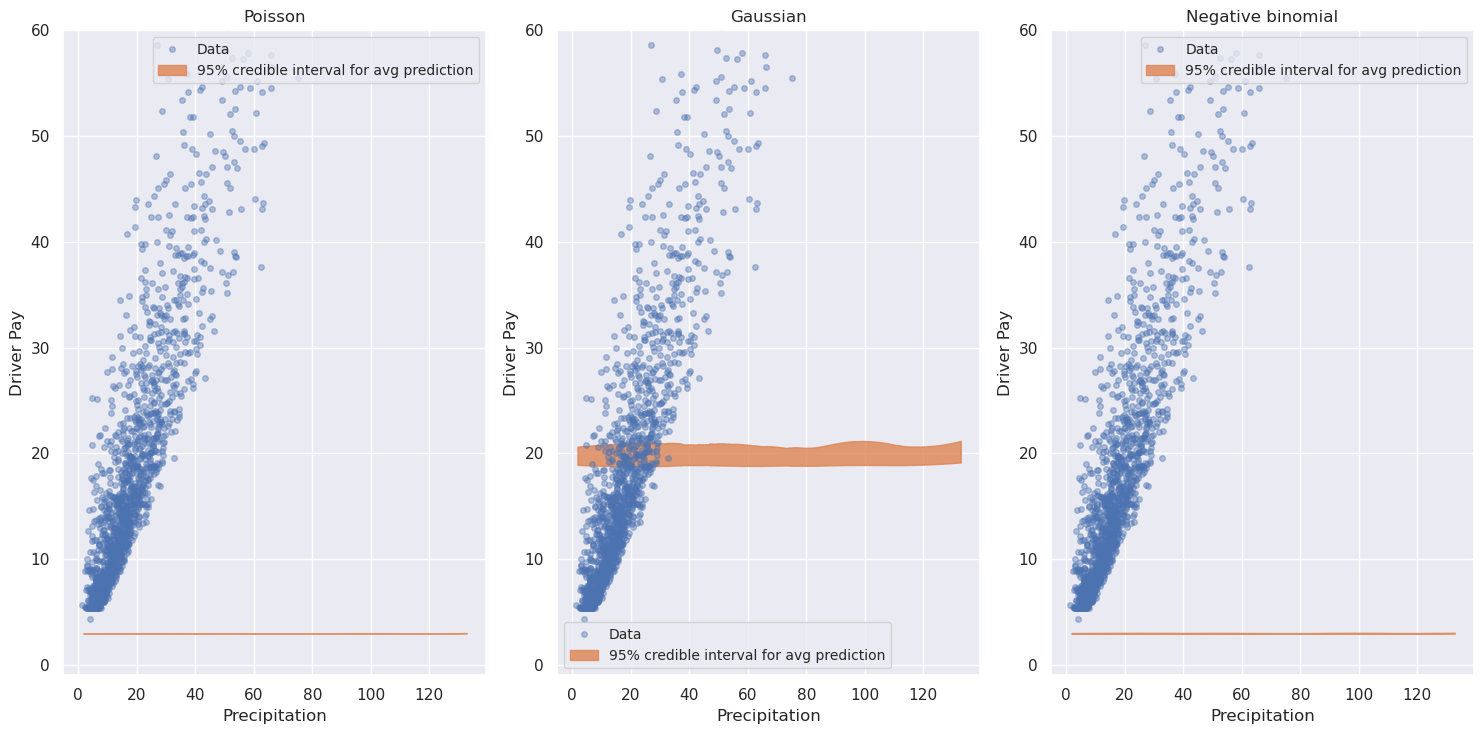

In [49]:
_, ax = plt.subplots(1,3, figsize = (15,7.5), dpi=100)
names = ["Poisson", "Gaussian", "Negative binomial"]

for idx, ppc in enumerate([poisson_ppc, gaussian_ppc, negbin_ppc]):
    ax[idx].plot(sample.trip_minutes, sample.driver_pay, "o", ms=4, alpha=0.4, label="Data")
    az.plot_hdi(
        sample.trip_minutes,
        y_hat_vals[idx],
        ax=ax[idx],
        hdi_prob=0.95,
        fill_kwargs={"alpha": 0.8, "label": "95% credible interval for avg prediction"},
    )
    if idx==1:
        pp_y = np.exp(ppc["y"])
    else:
        pp_y = ppc["y"]

    ax[idx].set_xlabel("Precipitation")
    ax[idx].set_ylabel("Driver Pay")
    ax[idx].set_title(names[idx])
    ax[idx].legend(fontsize=10)
    ax[idx].set_ylim(-1, 60)
plt.tight_layout()

## `trip_minutes` & `trip_miles`
------
Predicting `driver_pay` with `trip_minutes` and  `trip_miles`

In [9]:
# Bayesian regression model using Gaussian likelihood (equivalent to OLS)
with pm.Model() as gaussian_model:
    glm.GLM.from_formula('driver_pay ~ trip_miles + trip_minutes + precipitation', 
                        data = sample)
    # draw posterior samples using NUTS sampling
    gaussian_trace = pm.sample(1000, cores=1, target_accept=0.95, return_inferencedata = True)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Sequential sampling (2 chains in 1 job)
NUTS: [sd, precipitation, trip_minutes, trip_miles, Intercept]


/opt/anaconda3/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/lib/python3.8/site-packages/theano/scalar/basic.py:2893: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/opt/anaconda3/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/lib/python3.8/site-packages/theano/scalar/basic.py:1955: RuntimeWarning: invalid value encountered in true_divide
  return x / y


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11314 seconds.


In [10]:
# Bayesian regression model using Gaussian likelihood (equivalent to OLS)
with pm.Model() as gaussian_model:
    glm.GLM.from_formula('driver_pay ~ trip_miles + trip_minutes', 
                        data = sample)
    # draw posterior samples using NUTS sampling
    gaussian_trace = pm.sample(1000, cores=1, target_accept=0.95, return_inferencedata = True)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Sequential sampling (2 chains in 1 job)
NUTS: [sd, trip_minutes, trip_miles, Intercept]


/opt/anaconda3/lib/python3.8/site-packages/theano/scalar/basic.py:3167: RuntimeWarning: overflow encountered in double_scalars
  return x * x
/opt/anaconda3/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: overflow encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/lib/python3.8/site-packages/theano/scalar/basic.py:2893: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/opt/anaconda3/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/anaconda3/lib/python3.8/site-packages/theano/scalar/basic.py:1955: RuntimeWarning: invalid value encountered in true_divide
  return x / y
/opt/anaconda3/lib/python3

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10293 seconds.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'trip_miles'}>,
        <AxesSubplot:title={'center':'trip_miles'}>],
       [<AxesSubplot:title={'center':'trip_minutes'}>,
        <AxesSubplot:title={'center':'trip_minutes'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

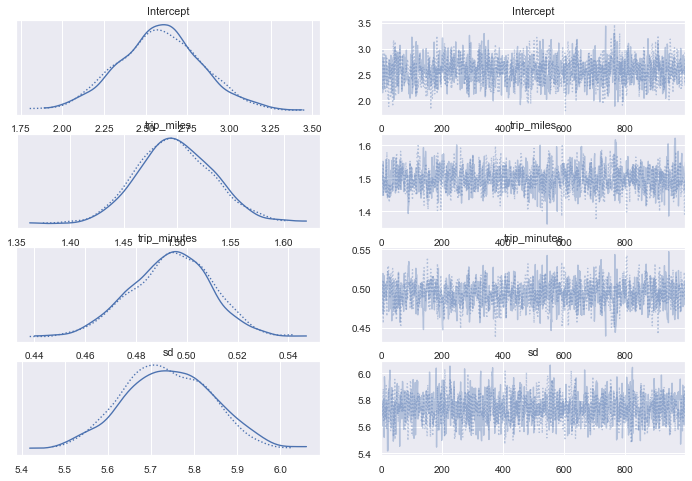

In [14]:
az.plot_trace(gaussian_trace)

<a id="11"></a>
## Frequentist GLMs

In [18]:
#Rids of any data that. has tips < 0 otherwise Tweedie and Gamma GLMs won't run
relevant_data = relevant_data[relevant_data['driver_pay'] >=0]

In [19]:
#Isolates the exogenous variables
exog = relevant_data[['trip_miles',
                      'trip_minutes',
                      'precipitation',
                      'hour']]

### Gaussian Model

In [10]:
gaussian_model = sm.GLM(
    relevant_data.driver_pay, 
    sm.add_constant(exog),
    family=sm.families.Gaussian()
)
gaussian_results = gaussian_model.fit()
print(gaussian_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             driver_pay   No. Observations:              3063921
Model:                            GLM   Df Residuals:                  3063916
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                          31.530
Method:                          IRLS   Log-Likelihood:            -9.6342e+06
Date:                Sun, 11 Dec 2022   Deviance:                   9.6607e+07
Time:                        21:33:12   Pearson chi2:                 9.66e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9989
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.6786      0.009    192.711

### Poisson Model

In [11]:
poisson_model = sm.GLM(
    relevant_data.driver_pay, 
    sm.add_constant(exog),
    family=sm.families.Poisson()
)
poisson_results = poisson_model.fit()
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             driver_pay   No. Observations:              3063921
Model:                            GLM   Df Residuals:                  3063916
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3894e+07
Date:                Sun, 11 Dec 2022   Deviance:                   1.3763e+07
Time:                        21:33:25   Pearson chi2:                 1.40e+07
No. Iterations:                    16   Pseudo R-squ. (CS):             0.9919
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.5506      0.000   8095.885

### Tweedie Model

In [20]:
tweedie_model = sm.GLM(
    relevant_data.driver_pay, 
    sm.add_constant(exog),
    family=sm.families.Tweedie()
)
tweedie_results = tweedie_model.fit()
print(tweedie_results.summary())

/Users/kareena/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1582: RuntimeWarning: divide by zero encountered in log
  endog * np.log(endog / mu) + (mu - endog))
/Users/kareena/opt/miniconda3/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1582: RuntimeWarning: invalid value encountered in multiply
  endog * np.log(endog / mu) + (mu - endog))


                 Generalized Linear Model Regression Results                  
Dep. Variable:             driver_pay   No. Observations:              3063920
Model:                            GLM   Df Residuals:                  3063915
Model Family:                 Tweedie   Df Model:                            4
Link Function:                    Log   Scale:                          4.5781
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 11 Dec 2022   Deviance:                   1.3762e+07
Time:                        21:37:03   Pearson chi2:                 1.40e+07
No. Iterations:                    18   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.5506      0.001   3783.721

<a id="4"></a>
# Non-Parametric Methods

In [9]:
#Splits data into training and test data
from sklearn.model_selection import train_test_split

train, test = train_test_split(relevant_data, test_size = 0.3, random_state = 101)

<a id="5"></a>

## Decision Trees

In [17]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor()
reg = tree_model.fit(train[['precipitation', 'trip_time', 'trip_minutes', 'hour']], train['driver_pay'])
train['tree_pred'] = reg.predict(train[['precipitation', 'trip_time', 'trip_minutes', 'hour']])
test['tree_pred'] = reg.predict(test[['precipitation', 'trip_time', 'trip_minutes', 'hour']])

In [18]:
train_mae = np.sum((train["tree_pred"] - train["driver_pay"])) / len(train["tree_pred"])
test_mae = np.sum((test["tree_pred"] - test["driver_pay"])) / len(train["tree_pred"])

print('MAE')
print('--------------------')
print("Training set error for decision tree:", train_mae)
print("Test set error for decision tree:    ", test_mae)

MAE
--------------------
Training set error for decision tree: -2.723244027234963e-17
Test set error for decision tree:     0.001213646055639648


In [19]:
train_rmse = np.mean((train["tree_pred"] - train["driver_pay"]) ** 2) ** 0.5
test_rmse = np.mean((test["tree_pred"] - test["driver_pay"]) ** 2) ** 0.5

print('RMSE')
print('--------------------')
print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:    ", test_rmse)

RMSE
--------------------
Training set error for decision tree: 5.400245405571994
Test set error for decision tree:     7.945403535522636


<a id="6"></a>

## Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(max_features=1)
reg = forest_model.fit(train[['precipitation', 'trip_time', 'trip_minutes', 'hour']], train['driver_pay'])
train['forest_pred'] = reg.predict(train[['precipitation', 'trip_time', 'trip_minutes', 'hour']])
test['forest_pred'] = reg.predict(test[['precipitation', 'trip_time', 'trip_minutes', 'hour']])

In [16]:
train_mae = np.sum((train["tree_pred"] - train["driver_pay"])) / len(train["tree_pred"])
test_mae = np.sum((test["tree_pred"] - test["driver_pay"])) / len(train["tree_pred"])

print('MAE')
print('--------------------')
print("Training set error for decision tree:", train_mae)
print("Test set error for decision tree:    ", test_mae)

MAE
--------------------
Training set error for decision tree: -2.750410208528548e-17
Test set error for decision tree:     0.0012860453389906797


In [15]:
train_rmse = np.mean((train["forest_pred"] - train["driver_pay"]) ** 2) ** 0.5
test_rmse = np.mean((test["forest_pred"] - test["driver_pay"]) ** 2) ** 0.5

print('RMSE')
print('--------------------')
print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse)

RMSE
--------------------
Training set error for random forest: 5.59364103703355
Test set error for random forest:     7.359433544486811
